### Eleanor Gallay
### June 21, 2024

This notebook is my first attempt at using the Lasair API to plot a light curve. I used some code from their example notebooks and plotted the light curve for an arbitrary star that passed my Mercury Transit Zone Stars v1 filter. 

In [1]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt

from lasairmod import LasairError, lasair_client as lasair

In [14]:
#making an SQL query
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
objects.sgscore1
"""

tables = 'objects,sherlock_classifications,areas:158'


# here I just picked an object that passed my Mercury Transit Zone Stars v1 filter 
conditions = """
sherlock_classifications.classification in ('VS', 'BS', 'ORPHAN')
AND objects.objectId = 'ZTF19abtnyif'  
"""


L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 20)
except LasairError as e:
    print(e)


In [15]:
# Did we get anything - just crudely print out the results if so.
for row in results:
    try:
        print(row['objectId'],
              "%.5f" % row['ramean'],
              "%.5f" % row['decmean'],
              "%.5f" % row['mjdmin'],
              "%.5f" % row['mjdmax'],
              "%.2f" % row['magrmin'],
              "%.2f" % row['rmag'],
              row['classification'])
    except:
        print(row['objectId'],
              row['ramean'],
              row['decmean'],
              row['mjdmin'],
              row['mjdmax'],
              row['magrmin'],
              row['rmag'],
              row['classification'])
            

ZTF19abtnyif 294.79920 -27.56464 60459.43097 60482.39841 15.42 15.42 VS


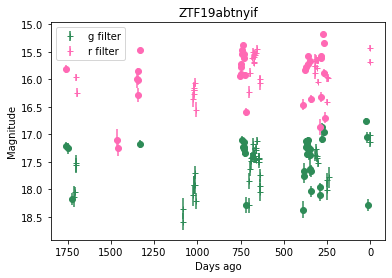

In [24]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'seagreen',2:'hotpink'}         # 1: g filter, 2: r filter

now = Time.now().jd

for obj in response:
        plt.figure()
        plt.subplot(111)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':        # 't' means positive difference magnitude, 'f' means negative
                    plt.errorbar(now - i['jd'],i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
                else:
                    plt.errorbar(now - i['jd'], i['magpsf'],i['sigmapsf'],fmt='+',color=cols[i['fid']])

        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
        plt.legend(["g filter", "r filter"])
